## **0. Import libraries**

In [1]:
import torch
import random
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)

## **1. Prepare dataset**


In [3]:
batch_size = 512

train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_ratio = 0.9
train_size = int(len(train_dataset) * train_ratio)
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train size: {len(train_subset)}")
print(f"Validation size: {len(val_subset)}")
print(f"Test size: {len(test_dataset)}")

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.5MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 198kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.71MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 6.40MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Train size: 54000
Validation size: 6000
Test size: 10000


## **2. Build MLP network**




In [15]:
class GradientNormalization(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return input

    @staticmethod
    def backward(ctx, grad_output):
        mean = torch.mean(grad_output)
        std = torch.std(grad_output)
        grad_input = (grad_output - mean) / (std + 1e-6)
        return grad_input

class GradientNormalizationLayer(nn.Module):
  def __init__(self):
    super(GradientNormalizationLayer, self).__init__()

  def forward(self, x):
    return GradientNormalization.apply(x)

In [16]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.grad_norm1 = GradientNormalizationLayer()
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.grad_norm2 = GradientNormalizationLayer()
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.grad_norm3 = GradientNormalizationLayer()
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.grad_norm4 = GradientNormalizationLayer()
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.grad_norm5 = GradientNormalizationLayer()
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.grad_norm6 = GradientNormalizationLayer()
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.grad_norm7 = GradientNormalizationLayer()
        self.output = nn.Linear(hidden_dims, output_dims)

        # Initialize weights and biases
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=1.0)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.grad_norm1(x)
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        x = self.grad_norm2(x)
        x = self.layer3(x)
        x = nn.Sigmoid()(x)
        x = self.grad_norm3(x)
        x = self.layer4(x)
        x = nn.Sigmoid()(x)
        x = self.grad_norm4(x)
        x = self.layer5(x)
        x = nn.Sigmoid()(x)
        x = self.grad_norm5(x)
        x = self.layer6(x)
        x = nn.Sigmoid()(x)
        x = self.grad_norm6(x)
        x = self.layer7(x)
        x = nn.Sigmoid()(x)
        x = self.grad_norm7(x)
        out = self.output(x)
        return out


In [17]:
input_dims = 784
hidden_dims = 128
output_dims = 10
lr = 1e-2

model = MLP(input_dims=input_dims,
            hidden_dims=hidden_dims,
            output_dims=output_dims).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

## **3. Training**

In [18]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(test_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/100, Train_Loss: 3.5638, Train_Acc: 0.1001, Validation Loss: 1.5154, Val_Acc: 0.0937
EPOCH 2/100, Train_Loss: 2.3529, Train_Acc: 0.1001, Validation Loss: 1.3817, Val_Acc: 0.1097
EPOCH 3/100, Train_Loss: 2.3030, Train_Acc: 0.0981, Validation Loss: 1.3817, Val_Acc: 0.1012
EPOCH 4/100, Train_Loss: 2.3029, Train_Acc: 0.1007, Validation Loss: 1.3822, Val_Acc: 0.0895
EPOCH 5/100, Train_Loss: 2.3030, Train_Acc: 0.0989, Validation Loss: 1.3818, Val_Acc: 0.1003
EPOCH 6/100, Train_Loss: 2.3029, Train_Acc: 0.0977, Validation Loss: 1.3819, Val_Acc: 0.1000
EPOCH 7/100, Train_Loss: 2.3028, Train_Acc: 0.1011, Validation Loss: 1.3821, Val_Acc: 0.1022
EPOCH 8/100, Train_Loss: 2.3029, Train_Acc: 0.1003, Validation Loss: 1.3823, Val_Acc: 0.0937
EPOCH 9/100, Train_Loss: 2.3029, Train_Acc: 0.0999, Validation Loss: 1.3816, Val_Acc: 0.1018
EPOCH 10/100, Train_Loss: 2.3030, Train_Acc: 0.0972, Validation Loss: 1.3816, Val_Acc: 0.1003
EPOCH 11/100, Train_Loss: 2.3029, Train_Acc: 0.0982, Validation Loss:

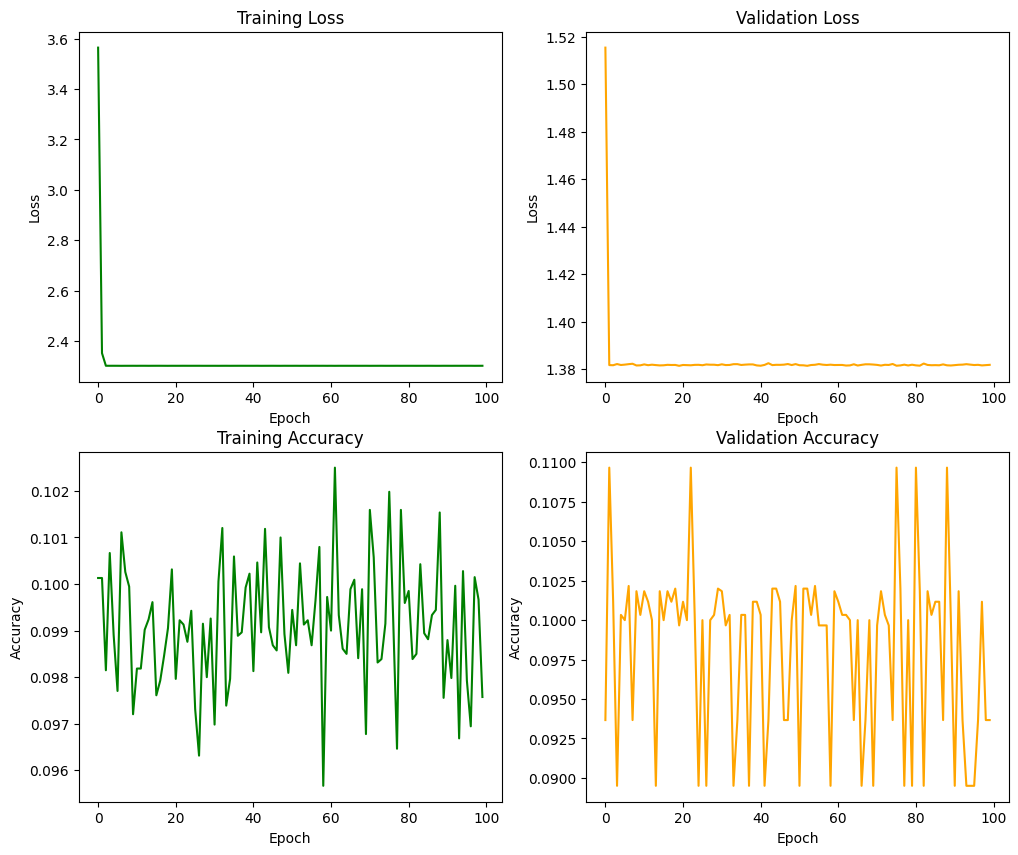

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

## **4. Evaluation**

In [20]:
val_target = []
val_predict = []

model.eval()
with torch.no_grad():
    for X_val, y_val in val_loader:
        X_val = X_val.to(device)
        y_val = y_val.to(device)
        outputs = model(X_val)

        val_predict.append(outputs.cpu())
        val_target.append(y_val.cpu())

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = (torch.argmax(val_predict, 1) == val_target).sum().item() / len(val_target)

    print('Evaluation on val set:')
    print(f'Accuracy: {val_acc}')

Evaluation on val set:
Accuracy: 0.09366666666666666


In [21]:
test_target = []
test_predict = []

model.eval()
with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        outputs = model(X_test)

        test_predict.append(outputs.cpu())
        test_target.append(y_test.cpu())

    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = (torch.argmax(test_predict, 1) == test_target).sum().item() / len(test_target)

    print('Evaluation on test set:')
    print(f'Accuracy: {test_acc}')

Evaluation on test set:
Accuracy: 0.1
